In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import bottleneck as bn # library used for moving average

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Activation
from keras.optimizers import SGD
from keras.layers import Dense, Dropout,BatchNormalization
from keras.regularizers import l2
from keras.layers import LSTM
from keras.layers import Dropout

In [11]:
file_path = 'Project/measures_v2.csv'

df = pd.read_csv(file_path)

df.head()

u_q    coolant  stator_winding       u_d  stator_tooth  motor_speed  \
0 -0.450682  18.805172       19.086670 -0.350055     18.293219     0.002866   
1 -0.325737  18.818571       19.092390 -0.305803     18.294807     0.000257   
2 -0.440864  18.828770       19.089380 -0.372503     18.294094     0.002355   
3 -0.327026  18.835567       19.083031 -0.316199     18.292542     0.006105   
4 -0.471150  18.857033       19.082525 -0.332272     18.291428     0.003133   

        i_d       i_q         pm  stator_yoke    ambient    torque  profile_id  
0  0.004419  0.000328  24.554214    18.316547  19.850691  0.187101          17  
1  0.000606 -0.000785  24.538078    18.314955  19.850672  0.245417          17  
2  0.001290  0.000386  24.544693    18.326307  19.850657  0.176615          17  
3  0.000026  0.002046  24.554018    18.330833  19.850647  0.238303          17  
4 -0.064317  0.037184  24.565397    18.326662  19.850639  0.208197          17

In [12]:
# Unique value of the measurement sessions
unique_values = df['profile_id'].unique()
print(unique_values)

[17  5 12 32 21  2  4  7 19  3  9 23 27 26 11  6 10 13 31 18 30 29  8 24
 20 15 14 16 36 74 75 41 68 50 53 49 81 80 59 54 57 70 51 55 45 69 61 76
 56 64 72 73 62 65 63 43 47 66 42 48 67 44 79 52 60 46 58 78 71]


In [13]:
# This function applies z-score normalization to all the features in the dataset except from the profile id
def apply_z_score_normalization_except_profile_id(df):

    profile_id = df['profile_id']
    df_to_scale = df.drop('profile_id', axis=1)

    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_to_scale)

    df_scaled = pd.DataFrame(df_scaled, columns=df_to_scale.columns)

    df_scaled['profile_id'] = profile_id

    return df_scaled

In [14]:
df_norm = apply_z_score_normalization_except_profile_id(df)

In [15]:
# This function applies z-score normalization to all the features in the dataset except from the profile id
def apply_z_score_normalization_except_profile_id(df):

    profile_id = df['profile_id']
    df_to_scale = df.drop('profile_id', axis=1)

    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_to_scale)

    df_scaled = pd.DataFrame(df_scaled, columns=df_to_scale.columns)

    df_scaled['profile_id'] = profile_id

    return df_scaled

In [16]:
def add_ewa_features_by_profile_id(df, spans, exclude_columns):
    
    exclude_columns = set(exclude_columns) | {'profile_id'}
    original_columns = [col for col in df.columns if col not in exclude_columns]

    # Iterate over each original column
    for col in original_columns:
        # Apply EWA for each span value
        for span in spans:
            ewa_col_name = f'{col}_ewa_{span}'

            # Group by 'profile_id' and apply EWA using transform
            ewa_col = df.groupby('profile_id')[col].transform(lambda x: x.ewm(span=span, adjust=False).mean())

            # Add the new EWA column to the DataFrame
            df[ewa_col_name] = ewa_col

    return df

In [17]:
exclude_columns = ['stator_winding']

spans = [600]

data_df = add_ewa_features_by_profile_id(df_norm, spans, exclude_columns)

features = data_df.columns
print(features)

Index(['u_q', 'coolant', 'stator_winding', 'u_d', 'stator_tooth',
       'motor_speed', 'i_d', 'i_q', 'pm', 'stator_yoke', 'ambient', 'torque',
       'profile_id', 'u_q_ewa_600', 'coolant_ewa_600', 'u_d_ewa_600',
       'stator_tooth_ewa_600', 'motor_speed_ewa_600', 'i_d_ewa_600',
       'i_q_ewa_600', 'pm_ewa_600', 'stator_yoke_ewa_600', 'ambient_ewa_600',
       'torque_ewa_600'],
      dtype='object')


In [18]:
data_df.head()

u_q   coolant  stator_winding       u_d  stator_tooth  motor_speed  \
0 -1.238979 -0.799812       -1.648158  0.392820     -1.681117    -1.184128   
1 -1.236150 -0.799197       -1.647959  0.393521     -1.681047    -1.184129   
2 -1.238757 -0.798729       -1.648064  0.392464     -1.681078    -1.184128   
3 -1.236180 -0.798417       -1.648285  0.393356     -1.681146    -1.184126   
4 -1.239442 -0.797432       -1.648303  0.393101     -1.681195    -1.184127   

        i_d       i_q        pm  stator_yoke  ...  coolant_ewa_600  \
0  1.058337 -0.405855 -1.786837    -1.494244  ...        -0.799812   
1  1.058278 -0.405867 -1.787686    -1.494323  ...        -0.799810   
2  1.058289 -0.405854 -1.787338    -1.493755  ...        -0.799807   
3  1.058270 -0.405836 -1.786847    -1.493529  ...        -0.799802   
4  1.057279 -0.405455 -1.786248    -1.493738  ...        -0.799794   

   u_d_ewa_600  stator_tooth_ewa_600  motor_speed_ewa_600  i_d_ewa_600  \
0     0.392820             -1.681117            -1.184128     1.058337   
1     0.392822             -1.681116            -1.184128     1.058337   
2     0.392821             -1.681116            -1.184128     1.058337   
3     0.392823             -1.681116            -1.184128     1.058337   
4     0.392823             -1.681117            -1.184128     1.058333   

   i_q_ewa_600  pm_ewa_600  stator_yoke_ewa_600  ambient_ewa_600  \
0    -0.405855   -1.786837            -1.494244        -2.443386   
1    -0.405855   -1.786840            -1.494244        -2.443386   
2    -0.405855   -1.786841            -1.494242        -2.443386   
3    -0.405855   -1.786841            -1.494240        -2.443386   
4    -0.405854   -1.786839            -1.494238        -2.443386   

   torque_ewa_600  
0       -0.400838  
1       -0.400836  
2       -0.400836  
3       -0.400834  
4       -0.400833  

[5 rows x 24 columns]

In [21]:
# Seperating input and output variables
X = data_df.drop(['stator_winding', 'profile_id'], axis=1).loc[:,'u_q':'torque_ewa_600'].values 
y = data_df.loc[:,'stator_winding'].values 

# split up in training and test data
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.3)

In [32]:
print(X[0])

[-1.23897895 -0.79981228  0.39281962 -1.68111651 -1.18412759  1.05833717
 -0.40585491 -1.78683673 -1.49424355 -2.4433861  -0.40083802 -1.23897895
 -0.79981228  0.39281962 -1.68111651 -1.18412759  1.05833717 -0.40585491
 -1.78683673 -1.49424355 -2.4433861  -0.40083802]


In [33]:
print(y[0])

-1.6481582341604706


In [22]:
X.shape

(1330816, 22)

In [23]:
# training the Random Forest Regressor on the dataset
from sklearn.ensemble import RandomForestRegressor
RFR_model = RandomForestRegressor(n_estimators = 10, random_state = 0)
RFR_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=0)

In [24]:
# Calculate MSE and MAE for the entire testset
y_pred = RFR_model.predict(X_test)
RFR_MSE = mean_squared_error(y_test, y_pred)
RFR_MAE = mean_absolute_error(y_test, y_pred)
print("MSE: {0}".format(RFR_MSE))
print("MAE: {0}".format(RFR_MAE))

MSE: 2.662486336183251e-05
MAE: 0.002227354955104293


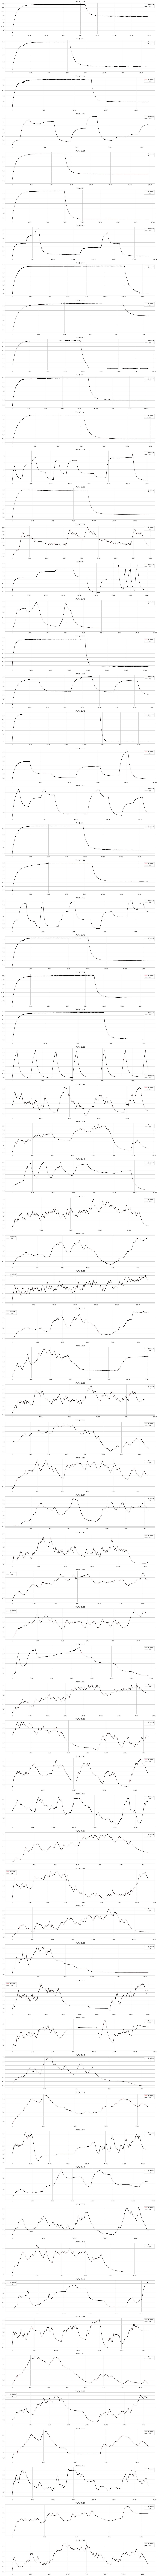

In [36]:


def plot_true_vs_predicted(model, data_df, profile_ids, output_value='stator_winding'):
    with sns.axes_style("whitegrid"):    
        fig, axs = plt.subplots(len(profile_ids), 1, figsize=(20, len(profile_ids) * 5), squeeze=False)
        
        for i, profile_id in enumerate(profile_ids):
            # Filter the data for the current profile_id
            profile_data = data_df[data_df['profile_id'] == profile_id]
            
            # Prepare the features for prediction
            X_plot = profile_data.drop(['stator_winding', 'profile_id'], axis=1).values
            y_true = profile_data[output_value].values

            # Predict
            y_pred = model.predict(X_plot)

            # Plotting
            time = np.linspace(0, len(y_true), num=len(y_true))
            axs[i, 0].plot(time, y_pred, label='Predicted', color='red', alpha=0.4, linewidth=0.8)
            axs[i, 0].plot(time, y_true, label='True', color='black', linewidth=1)
            axs[i, 0].legend(loc='best')
            axs[i, 0].set_title(f"Profile ID: {profile_id}")

        plt.show()

# Number of random profiles to select
num_profiles = 10

# Ensure that unique_values contains all unique profile IDs from your dataset
unique_values = df['profile_id'].unique()

# Randomly select 'num_profiles' unique profile IDs
test_run_list = np.random.choice(unique_values, size=num_profiles, replace=False)

# Now use the test_run_list in the plot function
plot_true_vs_predicted(RFR_model, data_df, unique_values)
